In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import random
import torch
import time
import numpy as np
from gensim.models.word2vec import Word2Vec
from model import BatchProgramClassifier
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

/home/david/projects/university/astnn/model.py:42: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if node[i][0] is not -1:
/home/david/projects/university/astnn/model.py:48: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if temp[j][0] is not -1:
/home/david/projects/university/astnn/model.py:69: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  batch_index = [i for i in batch_index if i is not -1]


## Load the Model

In [2]:
root = '/home/david/projects/university/astnn/data/'

word2vec = Word2Vec.load(root+"train/embedding/node_w2v_128").wv
embeddings = np.zeros((word2vec.vectors.shape[0] + 1, word2vec.vectors.shape[1]), dtype="float32")
embeddings[:word2vec.vectors.shape[0]] = word2vec.vectors

HIDDEN_DIM = 100
ENCODE_DIM = 128
LABELS = 104
EPOCHS = 15
BATCH_SIZE = 1
USE_GPU = False
MAX_TOKENS = word2vec.vectors.shape[0]
EMBEDDING_DIM = word2vec.vectors.shape[1]

model = BatchProgramClassifier(EMBEDDING_DIM,HIDDEN_DIM,MAX_TOKENS+1,ENCODE_DIM,LABELS,BATCH_SIZE,
                               USE_GPU, embeddings)
model.load_state_dict(torch.load("/home/david/projects/university/astnn/model.pt"))

<All keys matched successfully>

In [ ]:
word2vec = Word2Vec.load('/home/david/projects/university/astnn/data/train/embedding/node_w2v_128').wv
vocab = word2vec.vocab

In [93]:
print(model)
# print(model._modules['encoder'])

BatchProgramClassifier(
  (encoder): BatchTreeEncoder(
    (embedding): Embedding(8189, 128)
    (W_c): Linear(in_features=128, out_features=128, bias=True)
    (W_l): Linear(in_features=128, out_features=128, bias=True)
    (W_r): Linear(in_features=128, out_features=128, bias=True)
  )
  (root2label): Linear(in_features=128, out_features=104, bias=True)
  (bigru): GRU(128, 100, batch_first=True, bidirectional=True)
  (hidden2label): Linear(in_features=200, out_features=104, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Load some data

In [94]:
ast_data = pd.read_pickle(root+'test/test_.pkl')
block_data = pd.read_pickle(root+'test/blocks.pkl')

In [95]:
ast_data.head(n=10)

,id,code,label
45281,45281,"FileAST(ext=[FuncDef(decl=Decl(name='main',\n ...",3
40377,40377,"FileAST(ext=[Decl(name='s',\n ...",64
3220,3220,"FileAST(ext=[Decl(name='B',\n ...",90
20981,20981,"FileAST(ext=[FuncDef(decl=Decl(name='main',\n ...",98
36621,36621,"FileAST(ext=[FuncDef(decl=Decl(name='main',\n ...",26
29203,29203,"FileAST(ext=[FuncDef(decl=Decl(name='main',\n ...",53
15031,15031,"FileAST(ext=[Decl(name=None,\n ...",31
26307,26307,"FileAST(ext=[FuncDef(decl=Decl(name='main',\n ...",11
12163,12163,"FileAST(ext=[FuncDef(decl=Decl(name='main',\n ...",71
19003,19003,"FileAST(ext=[FuncDef(decl=Decl(name='sushu',\n...",68


In [96]:
block_data.head()

,id,code,label
45281,45281,"[[32, [2, [30, [40, [4]]]]], [6], [2, [13, [4]...",3
40377,40377,"[[32, [2, [30, [40, [81]]]]], [6], [2, [13, [4...",64
3220,3220,"[[32, [2, [30, [40, [4]]]]], [6], [2, [45, [4]...",90
20981,20981,"[[32, [2, [30, [40, [4]]]]], [6], [2, [23, [23...",98
36621,36621,"[[32, [2, [30, [40, [4]]]]], [6], [2, [0, [4]]...",26


An example record

In [333]:
# x = block_data['code'][45281]
# x = block_data['code'][40377]
x = block_data['code'][3220]


x

[[32, [2, [30, [40, [4]]]]],
 [6],
 [2, [45, [4]]],
 [2, [24, [4]]],
 [2, [13, [4]]],
 [59, [62], [45]],
 [16, [76, [2, [0, [4]], [5]]], [20, [0], [45]], [14, [0]]],
 [6],
 [59, [59, [62], [24]], [13]],
 [2, [55, [4]], [5]],
 [16, [76, [2, [8, [4]], [10]]], [34, [8], [13]], [14, [8]]],
 [77, [55], [11, [21], [12, [24], [8]]]],
 [28, [28, [51], [55]], [202]],
 [7],
 [39, [5]],
 [7],
 [32, [2, [30, [75, [2, [13, [4]]], [2, [22, [4]]]], [355, [4]]]]],
 [6],
 [15, [63, [19, [22], [10]], [19, [13], [22]]]],
 [39, [10]],
 [6],
 [15, [48, [22], [13]]],
 [39, [5]],
 [6],
 [2, [137, [4]], [5]],
 [16, [76, [2, [54, [4]], [22]]], [48, [54], [5]], [79, [54]]],
 [77, [137], [11, [21], [12, [18, [13], [22]], [54]]]],
 [39, [137]],
 [7],
 [7],
 [7]]

Elements represent indices of tokens in the word embedding

In [334]:
def index_to_token(node):
    i = node[0]
    result = [word2vec.index2word[i]]
    children = node[1:]
    for child in children:
        result.append(index_to_token(child))
    return result

token_blocks = []
for block in x:
    token_blocks.append(index_to_token(block))
    
token_blocks

[['FuncDef', ['Decl', ['FuncDecl', ['main', ['int']]]]],
 ['Compound'],
 ['Decl', ['t', ['int']]],
 ['Decl', ['m', ['int']]],
 ['Decl', ['n', ['int']]],
 ['>>', ['cin'], ['t']],
 ['For',
  ['DeclList', ['Decl', ['i', ['int']], ['0']]],
  ['<', ['i'], ['t']],
  ['++', ['i']]],
 ['Compound'],
 ['>>', ['>>', ['cin'], ['m']], ['n']],
 ['Decl', ['sum', ['int']], ['0']],
 ['For',
  ['DeclList', ['Decl', ['j', ['int']], ['1']]],
  ['<=', ['j'], ['n']],
  ['++', ['j']]],
 ['+=', ['sum'], ['FuncCall', ['b'], ['ExprList', ['m'], ['j']]]],
 ['<<', ['<<', ['cout'], ['sum']], ["'\\n'"]],
 ['End'],
 ['Return', ['0']],
 ['End'],
 ['FuncDef',
  ['Decl',
   ['FuncDecl',
    ['ParamList', ['Decl', ['n', ['int']]], ['Decl', ['k', ['int']]]],
    ['B', ['int']]]]],
 ['Compound'],
 ['If', ['||', ['==', ['k'], ['1']], ['==', ['n'], ['k']]]],
 ['Return', ['1']],
 ['Compound'],
 ['If', ['>', ['k'], ['n']]],
 ['Return', ['0']],
 ['Compound'],
 ['Decl', ['result', ['int']], ['0']],
 ['For',
  ['DeclList', ['Dec

What do these statement trees look like

In [335]:
import networkx as nx

def add_to_graph(G, block, pi, label_dict):
    token = block[0]
    i = len(G)
    G.add_nodes_from([(i, {'label': token})])
    label_dict[i] = token
    
    if pi != None:
        G.add_edge(pi, i)
    
    children = block[1:]
    for child in children:
        add_to_graph(G, child, i, label_dict)

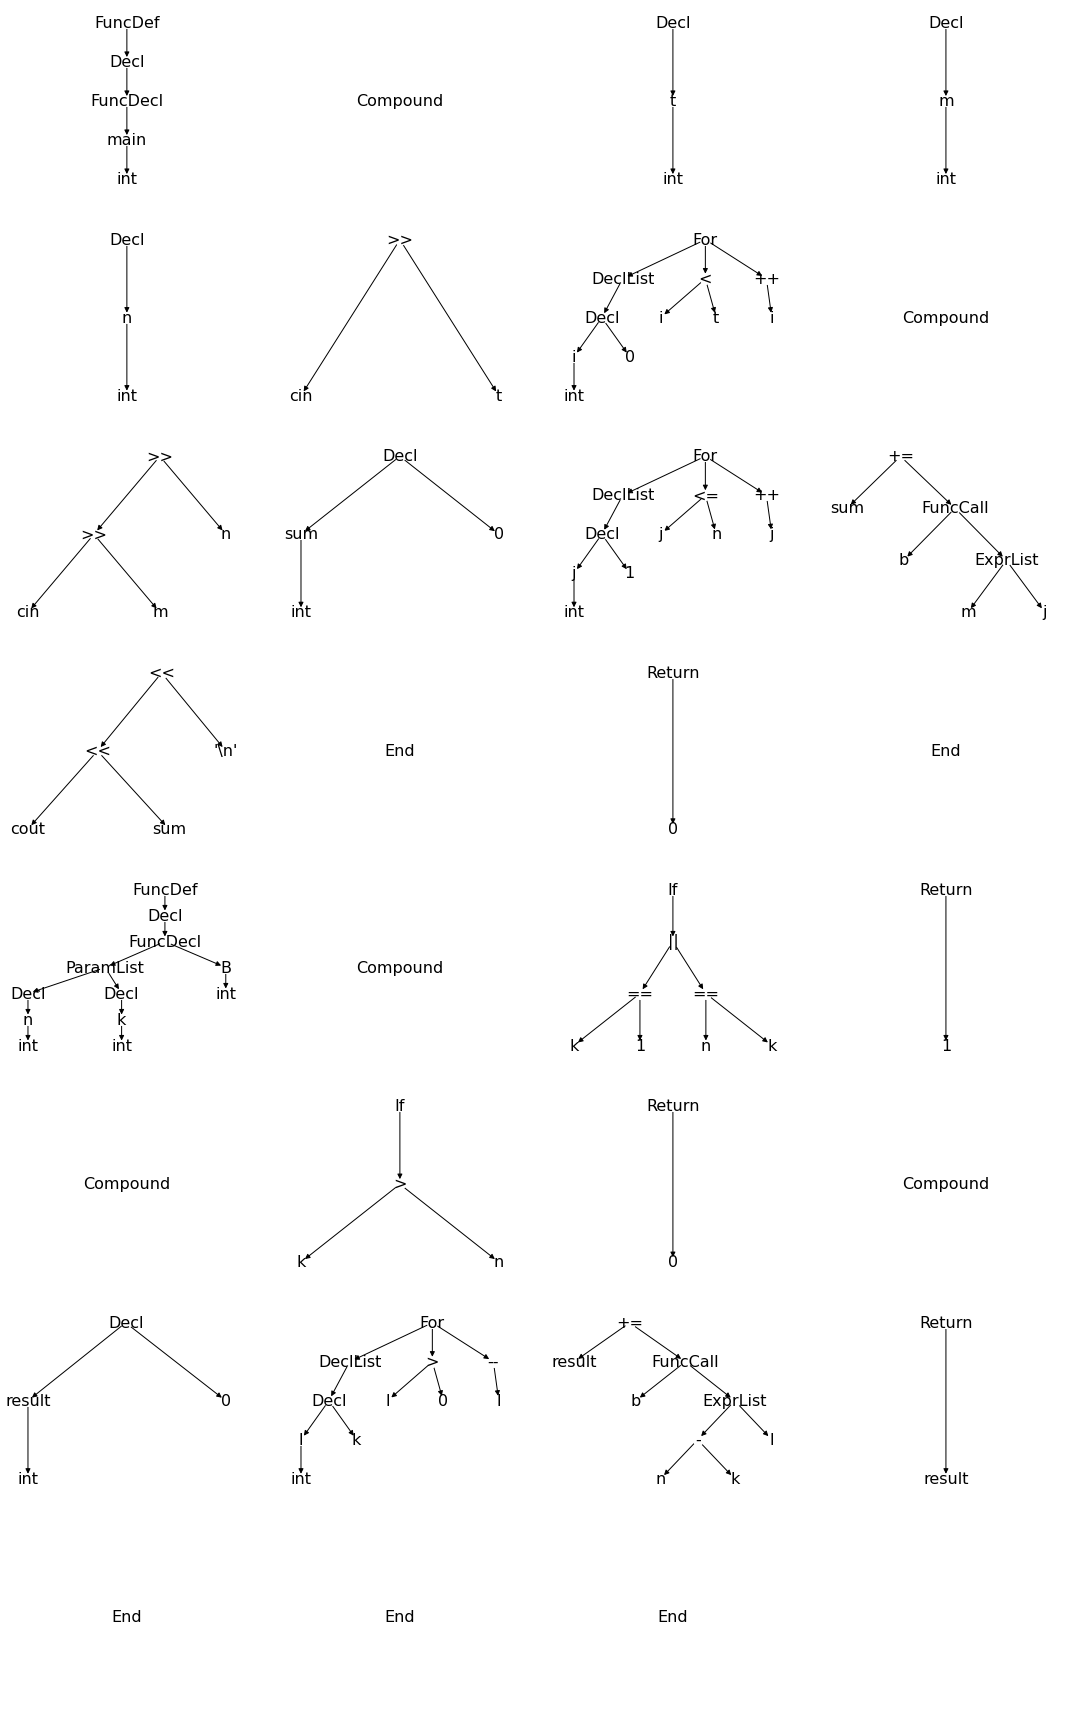

In [336]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

plt.figure(figsize=(15,30))

options = {
    'node_color': 'white',
    'node_size': 100,
    'width': 1,
    'font_size': 16
}

for i, block in enumerate(token_blocks):
    G = nx.DiGraph()
    label_dict = {}
    add_to_graph(G, block, None, label_dict)
    
    pos=graphviz_layout(G, prog='dot')

    plt.subplot(10, 4, i+1)
    plt.tight_layout()
    nx.draw(G, pos, **options, with_labels=True, labels=label_dict)


Need a method to find all the embedding locations

And the source code

In [101]:
from pycparser import c_ast, c_parser, c_generator

parser = c_parser.CParser()
generator = c_generator.CGenerator()


ast = ast_data['code'][45281]
print(generator.visit(ast))

int main()
{
  int n;
  int k;
  int m[1000];
  int i;
  int j;
  scanf("%d%d", &n, &k);
  for (i = 0; i < n; i++)
    scanf("%d", &m[i]);

  for (i = 0; i < n; i++)
  {
    for (j = i + 1; j < n; j++)
      if ((m[i] + m[j]) == k)
      break;


    if (j != n)
      break;

  }

  if (i == n)
    printf("no");
  else
    printf("yes");

  return 0;
}




Example grad calculation

In [102]:
loss_function = torch.nn.CrossEntropyLoss()

labels = torch.LongTensor([2])
output = model([x])
loss = loss_function(output, Variable(labels))
# for l in model._modules['encoder'].embedding_list:
#     l.retain_grad()
loss.backward()

Node List represents the node embeddings

In [103]:
n_list = model._modules['encoder'].node_list
n_list.size()

torch.Size([22, 23, 128])

In [240]:
n_list[9, 8, :]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0004, 0.0000, 0.0000, 0.0002,
        0.0004, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

- 128: embedding dimension of the node
- 23: dimension for each block (statement tree)
- 22: dimension for node position in the statement tree

## Generate the embeddings for our vocab

Construct embedder for leaf nodes

In [255]:
leaf_embed = nn.Sequential(
    model._modules['encoder']._modules['embedding'],
    model._modules['encoder']._modules['W_c']
)

define rules for allowed variables

In [288]:
# words we wont allow as variable names
reserved_words = [
    'auto',
    'break',
    'case',
    'char',
    'const',
    'continue',
    'defualt',
    'do',
    'int',
    'long',
    'register',
    'return',
    'short',
    'sizeof',
    'static',
    'struct',
    'switch',
    'typedef',
    'union',
    'unsigned',
    'void',
    'volatile',
    'while',
    'double',
    'else',
    'enum',
    'extern',
    'float',
    'for',
    'goto',
    'if',
    'printf',
    'scanf'
]

import re

def allowed_variable(var):
    pattern = re.compile("([a-z]|[A-Z]|_)+([a-z]|[A-Z]|[0-9]|_)*$")
    if (var not in reserved_words) and pattern.match(var):
        return True
    else:
        return False

allowed_variable('scanf')

False

In [289]:

embedding_map = {}

for index in range(len(vocab)):
    if allowed_variable(word2vec.index2word[index]):
        embedding_map[index] = leaf_embed(torch.tensor(index)).detach().numpy()

## Functions used to replace a variable name

In [290]:
def replace_index(node, old_i, new_i):
    i = node[0]
    if i == old_i:
        result = [new_i]
    else:
        result = [i]
    children = node[1:]
    for child in children:
        result.append(replace_index(child, old_i, new_i))
    return result

def replace_var(x, old_i, new_i):
    mod_blocks = []
    for block in x:
        mod_blocks.append(replace_index(block, old_i, new_i))

    return mod_blocks

## Functions to get the closest variable

In [291]:
def l2_norm(a, b):
    return np.linalg.norm(a-b)

def cos_sim(a, b):
    return np.inner(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def closest_index(embedding, embedding_map, metric):
    closest_i = 0
#     closest_dist = l2_norm(embedding_map[closest_i], embedding)
    closest_dist = metric(embedding_map[closest_i], embedding)
    for i, e in embedding_map.items():
#         d = l2_norm(embedding_map[i], embedding)
        d = metric(embedding_map[i], embedding)
        if d < closest_dist:
            closest_dist = d
            closest_i = i
    return closest_i

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

## Functions to get the gradients

In [300]:
def get_embedding(indices, node_list):
    '''
    get the embedding at the index position in postorder traversal.
    '''
    res = []
    c = 0
    for i in range(node_list.size(0)):
        if not np.all(node_list[i].detach().numpy() == 0):
            if c in indices:
                res.append(node_list[i])
            c += 1
    return res

def post_order_loc(node, var, res, counter):
    index = node[0]
    children = node[1:]
    for child in children:
        res, counter = post_order_loc(child, var, res, counter)
    if var == index and (not children):
        res.append(counter) 
#         print(counter, word2vec.index2word[index])
    counter += 1
    return res, counter

## Pick our example

modify $v$ to $v + \epsilon g$

In [328]:
def gradient_method(x, var, epsilon, metric):

    _, orig_pred = torch.max(model([x]).data, 1)
    orig_pred = orig_pred.item()
    orig_index = vocab[var].index
    curr_index = vocab[var].index
    
    # get the grad
    loss_function = torch.nn.CrossEntropyLoss()
    labels = torch.LongTensor([orig_pred])
    output = model([x])
    loss = loss_function(output, Variable(labels))
    loss.backward()
    n_list = model._modules['encoder'].node_list
    
    grads = []
    for i, block in enumerate(x):
        indices, _ = post_order_loc(block, orig_index, [], 0)
        grads += get_embedding(indices, n_list.grad[:, i, :])

    grad = torch.stack(grads).sum(dim=0)
    
    v = node_embedding.detach().numpy()
    g = torch.sign(grad).detach().numpy()
    # g = normalize(grad.detach().numpy())

    for _ in range(100):
        v = v + epsilon * g
        # get the closest emebedding from our map
        i = closest_index(v, embedding_map, metric)
        if i != curr_index:
            new_x = replace_var(x, orig_index, i)
            o = model([new_x])
            _, predicted = torch.max(o.data, 1)
            print(i, ":", word2vec.index2word[i], ":", predicted.item())
            curr_index = i
            if predicted.item() != orig_pred:
                return new_x
    print("couldn't find adversarial example")
    return None
    
    



In [337]:
# x = block_data['code'][45281]
# x = block_data['code'][40377]
x = block_data['code'][3220]


In [338]:
print('fast gradient sign method, cosine similariy')
new_x_cos = gradient_method(x, 'k', 0.1, cos_sim)
print('fast gradient sign method, l2 norm')
new_x_l2 = gradient_method(x, 'k', 0.1, l2_norm)

fast gradient sign method, cosine similariy
236 : cos : 66
fast gradient sign method, l2 norm
0 : i : 89
8 : j : 89
1216 : smax : 5


## The adversarial example

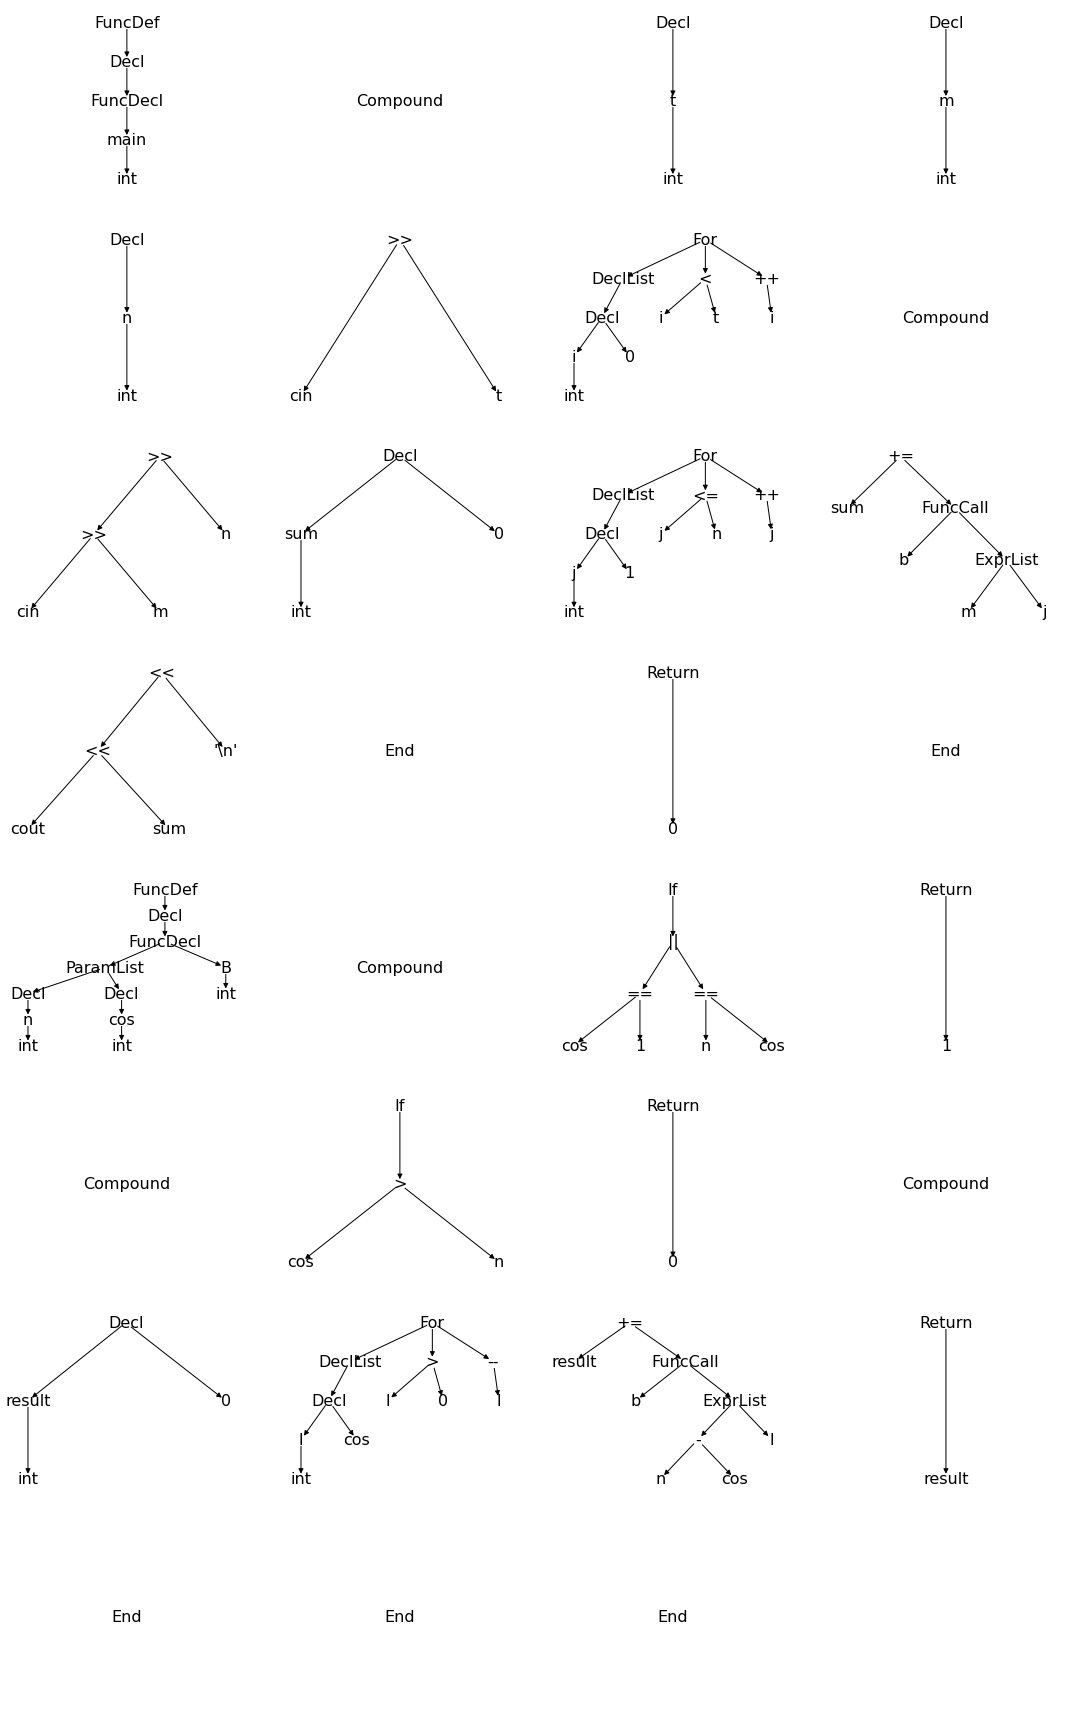

In [339]:
token_blocks = []
for block in new_x_cos:
    token_blocks.append(index_to_token(block))
    
plt.figure(figsize=(15,30))

for i, block in enumerate(token_blocks):
    G = nx.DiGraph()
    label_dict = {}
    add_to_graph(G, block, None, label_dict)
    
    pos=graphviz_layout(G, prog='dot')

    plt.subplot(10, 4, i+1)
    plt.tight_layout()
    nx.draw(G, pos, **options, with_labels=True, labels=label_dict)

reproduce prev results

# Training Accuracy

## No modifications

- Testing results(Acc): 0.9804826458994328

## Dead Code Additions

- 2 additions: Testing results(Acc): 0.9753869820209595
- 5 additions: Testing results(Acc): 0.9682722815113931


## Variable Renaming

- Testing results(Acc): 0.9478896259975003

## Combination

- Variable renaming, 5 dead code additions: Testing results(Acc): 0.9473127583886165
- Variable renaming, 10 dead code additions: Testing results(Acc): 0.946928179982694

# Efficiency Notes

## Variable renaming
- Test set (10401 code samples): ~1m 8s